In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Fakenews/train.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
df.head(5)


Mounted at /content/drive


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [2]:
print(df.shape)
df.isna().sum()

(20800, 5)


id           0
title      558
author    1957
text        39
label        0
dtype: int64

,title,label
0,The Island of Happiness in the Sea of Suffering,1
1,DELINGPOLE: NASA to Stop Shilling for Big Gree...,0
2,"Part 1: Poverty and Crime: ""We can hire half t...",1
3,Florida Election Worker Goes Public With Massi...,1
4,Will Barack Obama Delay Or Suspend The Electio...,1
...,...,...
20237,Arsonist Sets Trump International Hotel in Las...,0
20238,More Women in Their 60s and 70s Are Having ‘Wa...,0
20239,Migrants Applying For Asylum in Australia from...,0
20240,Comment on 500 Year Old Map Was Discovered Tha...,1


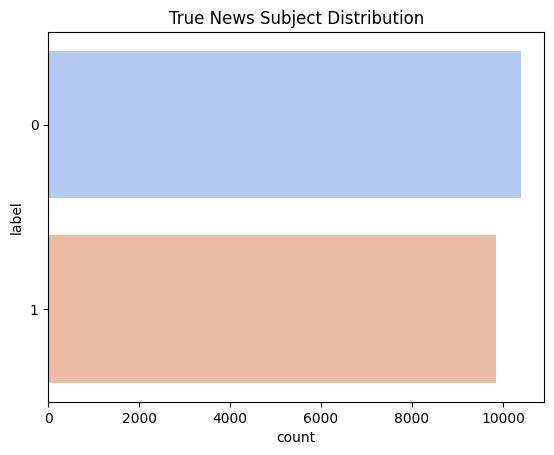

In [3]:
from sklearn.utils import shuffle

df = df[~df['title'].isna()][['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20242 entries, 0 to 20241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   label   20242 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 316.4+ KB


In [5]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19803 entries, 0 to 20241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19803 non-null  object
 1   label   19803 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 464.1+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 19803
Max length of the titles: 47
Mean length of the titles: 8.66696965106297
Median length of the titles: 9.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

# one_hot_rep=[one_hot(words,voc_size)for words in list_of_words] 
# padded_df=pad_sequences(one_hot_rep,padding='pre',truncating = 'post',maxlen=max_len)
# print(padded_df)

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = 20, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.01
optimizer = Adam(lr=0.001)
embedding_vector_features=60
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=20))
model.add(Dropout(0.3))
# model.add(LSTM(100))
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [12]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/5
228/228 [==============================] - 21s 12ms/step - loss: 2.4109 - accuracy: 0.8269 - val_loss: 1.4199 - val_accuracy: 0.9372
Epoch 2/5
228/228 [==============================] - 2s 8ms/step - loss: 1.0733 - accuracy: 0.9619 - val_loss: 0.8839 - val_accuracy: 0.9362
Epoch 3/5
228/228 [==============================] - 2s 10ms/step - loss: 0.5888 - accuracy: 0.9851 - val_loss: 0.6063 - val_accuracy: 0.9231
Epoch 4/5
228/228 [==============================] - 2s 9ms/step - loss: 0.3040 - accuracy: 0.9920 - val_loss: 0.4605 - val_accuracy: 0.9124
Epoch 5/5
228/228 [==============================] - 2s 7ms/step - loss: 0.1458 - accuracy: 0.9972 - val_loss: 0.3412 - val_accuracy: 0.9309


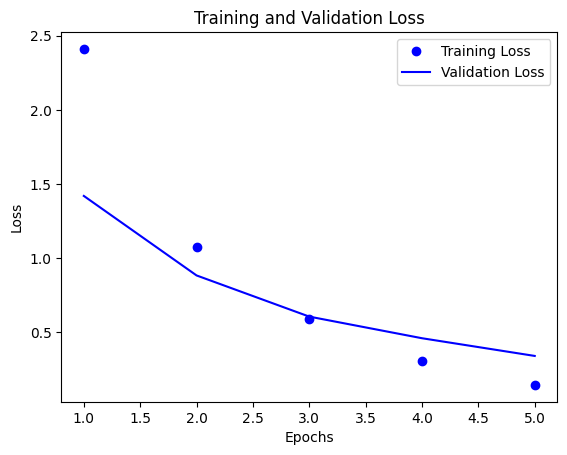

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 5)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

124/124 [==============================] - 1s 4ms/step
CNN-BiLSTM Model Accuracy :  0.924514011613229
Precision :  0.9184322033898306
Recall :  0.9228312932410857
F1 :  0.9206264932306876
G-mean: 0.9244305912531123
Training time:  48.135600566864014
Inference time:  2.1075356006622314
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2082
           1       0.92      0.92      0.92      1879

    accuracy                           0.92      3961
   macro avg       0.92      0.92      0.92      3961
weighted avg       0.92      0.92      0.92      3961



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


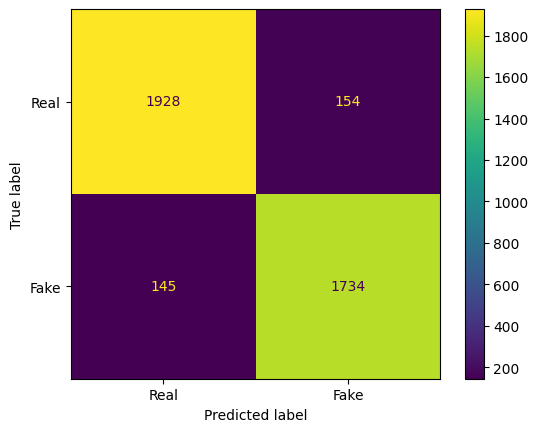

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real','Fake'])
disp.plot()